# Assignment 1

In this assignment you will work with Linear Regression and Gradient Descent. The dataset that you will use is the so-called *Boston house pricing dataset*.
## Preparation

First we'll load some libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv

## Boston House Pricing

### Pre-processing

In this part of the assignment you will try to predict the prices of houses in Boston. Let's load the data and see what's in it:

In [9]:
colnames = [label.strip() for label in open("columns.names").readline().rstrip().split(',')]
bdata = read_csv("housing.data", sep="\s+", header=None, names=colnames)
bdata.head() #take a look at the data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


It looks like we have some data! There are 13 different features in the dataset (from CRIM to LSTAT) and one value that we will try to predict based on the features (MEDV - median house price).
What kind of data exactly?

In [10]:
bdata.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

Mostly floats and some ints, now how many data points?

In [11]:
bdata.shape

(506, 14)

If we take a value of 0.8 as a treshold, the following features are highly collinear:
CRIM: TAX, RAD, NOX
NOX: TAX, DIS, CRIM
DIS: NOX
RAD: TAX, CRIM
TAX: RAD, CRIM

On the other, taking 0.5 as the limit MEDV seems to be correlated with LSTAT (0.82), PTRATIO (0.52), TAX (0.57), RM (0.69), NOX (0.53), INDUS (0.6), CRIM (0.57).

In the final feature selection for Linear Regression we will use LSTAT, PTRATIO, RM, INDUS and TAX. Neither CRIM nor NOX make it because of the collinearity with TAX.

It's also good to check if we have any missing data or NaN's (not-a-number) in the dataset:

In [12]:
print(bdata.isnull().sum())
print(bdata.isna().sum())

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


No and no - luckily no need to remove observations.

Now it's time to look closer into the data and see how it looks like. First, let's use the pandas `describe` method:

In [13]:
pd.set_option('display.precision', 1)
bdata.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,5.1e+02,506.0,506.0,5.1e+02,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0
mean,3.6e+00,11.4,11.1,6.9e-02,0.6,6.3,68.6,3.8,9.5,408.2,18.5,356.7,12.7,22.5
std,8.6e+00,23.3,6.9,2.5e-01,0.1,0.7,28.1,2.1,8.7,168.5,2.2,91.3,7.1,9.2
min,6.3e-03,0.0,0.5,0.0e+00,0.4,3.6,2.9,1.1,1.0,187.0,12.6,0.3,1.7,5.0
25%,8.2e-02,0.0,5.2,0.0e+00,0.4,5.9,45.0,2.1,4.0,279.0,17.4,375.4,6.9,17.0
50%,2.6e-01,0.0,9.7,0.0e+00,0.5,6.2,77.5,3.2,5.0,330.0,19.1,391.4,11.4,21.2
75%,3.7e+00,12.5,18.1,0.0e+00,0.6,6.6,94.1,5.2,24.0,666.0,20.2,396.2,17.0,25.0
max,8.9e+01,100.0,27.7,1.0e+00,0.9,8.8,100.0,12.1,24.0,711.0,22.0,396.9,38.0,50.0


As you can see there's lots of basic statistic for each column being printed. However since we are dealing with a regression problem it's far more interesting to see if there are any correlations between the features.
We can do it in text mode:

In [14]:
pd.set_option('display.precision', 2)
bdata.corr(method='pearson')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.00,-0.20,0.41,-5.59e-02,0.42,-0.22,0.35,-0.38,6.26e-01,0.58,0.29,-0.39,0.46,-0.39
ZN,-0.20,1.00,-0.53,-4.27e-02,-0.52,0.31,-0.57,0.66,-3.12e-01,-0.31,-0.39,0.18,-0.41,0.36
INDUS,0.41,-0.53,1.00,6.29e-02,0.76,-0.39,0.64,-0.71,5.95e-01,0.72,0.38,-0.36,0.60,-0.48
CHAS,-0.06,-0.04,0.06,1.00e+00,0.09,0.09,0.09,-0.10,-7.37e-03,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,9.12e-02,1.00,-0.30,0.73,-0.77,6.11e-01,0.67,0.19,-0.38,0.59,-0.43
RM,-0.22,0.31,-0.39,9.13e-02,-0.30,1.00,-0.24,0.21,-2.10e-01,-0.29,-0.36,0.13,-0.61,0.70
AGE,0.35,-0.57,0.64,8.65e-02,0.73,-0.24,1.00,-0.75,4.56e-01,0.51,0.26,-0.27,0.60,-0.38
DIS,-0.38,0.66,-0.71,-9.92e-02,-0.77,0.21,-0.75,1.00,-4.95e-01,-0.53,-0.23,0.29,-0.50,0.25
RAD,0.63,-0.31,0.60,-7.37e-03,0.61,-0.21,0.46,-0.49,1.00e+00,0.91,0.46,-0.44,0.49,-0.38
TAX,0.58,-0.31,0.72,-3.56e-02,0.67,-0.29,0.51,-0.53,9.10e-01,1.00,0.46,-0.44,0.54,-0.47


If we take a look at the last column we can see the correlations between the various features and the median house prices. Usually, correlations above (absolute value of) 0.5 are 'promissing' when it comes to building regression models. 
Here we will lower this limit to 0.4 and drop all the columns except: INDUS, NOX, RM, TAX, PTRATIO, LSTAT.

In [15]:
clean_data = bdata[['INDUS', 'NOX', 'RM', 'TAX', 'PTRATIO', 'LSTAT', 'MEDV']]

Let's split the data into the features and a vector of values:

In [16]:
features = clean_data.drop('MEDV', axis = 1)
prices = clean_data['MEDV']

### Linear Regression and Learning Curves

If you look at the data above you will notice that the features have different scales, to use the regression models you'll need to build a pipeline that uses scaling of the features:

In [17]:
# TODO: Build a scikit Pipeline that contains the scaling and linear regression
# make sure to name this pipeline: lin_regressor
# Score: 1 point


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

lin_regressor = Pipeline([('std_scaler', StandardScaler()),("lin_reg", LinearRegression())])

Having the pipeline build, now it's time to run linear regression:

1. Split the dataset into the training and validation sets
2. Train the model and see what's the RME on the training and on the validation data is
3. (Additionally) Wrap you code into a loop that will plot the learning curves by training your model against the data of different sizes.


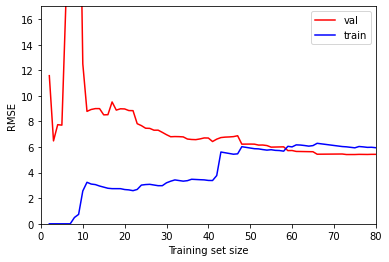

In [18]:
# TODO: Split the data into the training and validation data, train the model, plot the learning curves
# make sure that you call your split data sets as below and that you name the predicted values of the training set: y_train_predict
# Points 1 point for each item (3 points total)

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

training_set = []
validation_set = []
set_size = []
X_train, X_val, y_train, y_val = train_test_split(features, prices, test_size=(0.2))

for i in range(2,len(X_train)):
    lin_regressor.fit(X_train[:i], y_train[:i])
    y_train_predict = lin_regressor.predict(X_train[:i])
    y_val_predict = lin_regressor.predict(X_val)
    training_set.append(np.sqrt(mean_squared_error(y_train[:i], y_train_predict)))
    validation_set.append(np.sqrt(mean_squared_error(y_val, y_val_predict)))
    set_size.append(i)
    
plt.axis([0, 80,0, 17])  
plt.xlabel('Training set size')
plt.ylabel('RMSE')
plt.plot(set_size,validation_set,'r',label='val')
plt.plot(set_size,training_set,'b',label='train')
plt.legend(loc="upper right")
plt.show()

This doesn't look that impressive - the RMSE is around 5, which given that most values you are trying to predict are in the 20-30 range gives a prediction error of almost 25%! 
We can also plot the errors of our predictions (those are called *residuals*):

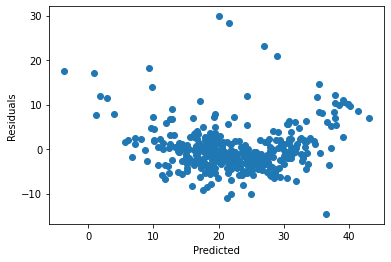

In [19]:
# Checking residuals
y_train_predict = lin_regressor.predict(X_train)
plt.scatter(y_train_predict, y_train-y_train_predict)
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

This plot gives us some hope - most of the errors fall in the +/-5 range except a few outliers - perhaps if we could somehow manipulate and clean the input data the results could be better. What's also curious is the shape of residuals that looks a bit like a quadratic function - perhaps we have some polynominal dependency?

## Data preprocessing

### Normalization

Let's look what our data actually looks like - this can be done by plotting histograms (or the density functions) of all the features in the dataset.

We can either use the Pandas dataframe fucntionality or rely on the seaborn library:

C:\Users\jelme\anaconda3\envs\Pyharm\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jelme\anaconda3\envs\Pyharm\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jelme\anaconda3\envs\Pyharm\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

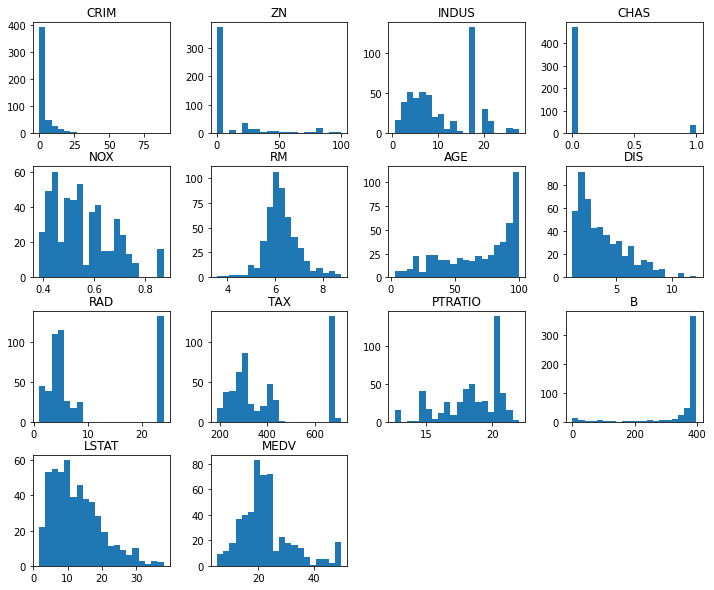

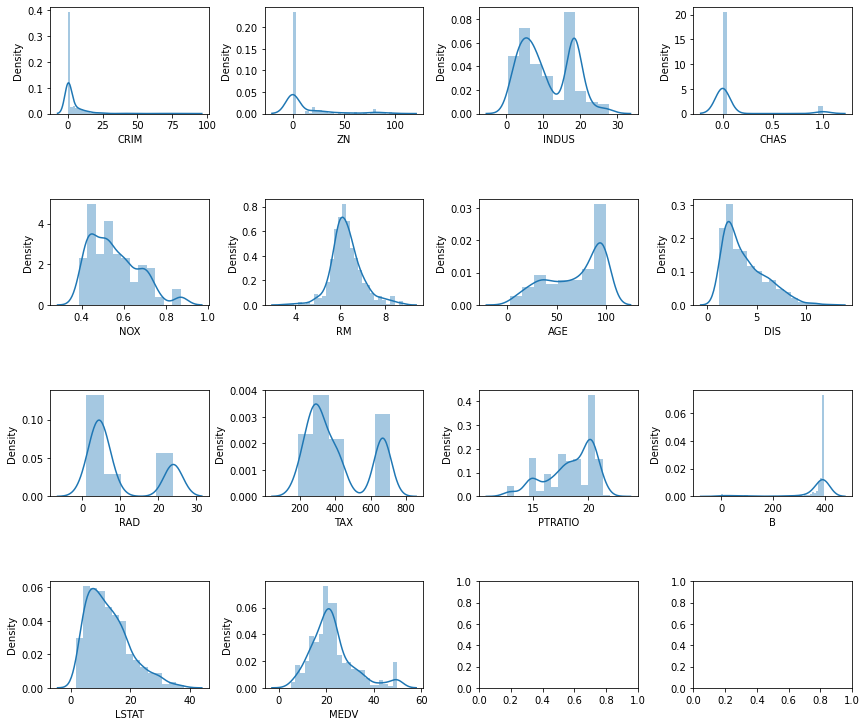

In [20]:
bdata.hist(bins=20,figsize=(12,10),grid=False);

# using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(12, 10))
index = 0
axs = axs.flatten()
for k, v in bdata.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Essentially, those are the same plots, the seaborn-generated ones are a bit nicer but that's the selling point of seaborn.
What you will notice is that our input data looks just awful. Only RM has a nice normal distribution, the rest not so much. We see exponential distributions (e.g. NOX, DIS), bimodal distributions (e.g. RAD, INDUS), weird peaks in data (e.g. ZN) and so on. This is all bad for Linear Regression which we are trying to use here - Linear Regression works the best with normally distributed data. Let's see if we can fix it somehow. We'll start by transforming features that are exponentially distributed - those are CRIM, NOX, DIS and LSTAT. To get rid of the exponentiation you need to take a logarithm - e.g for LSTAT the result looks like this:

C:\Users\jelme\anaconda3\envs\Pyharm\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='LSTAT', ylabel='Density'>

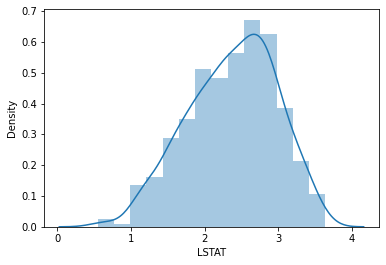

In [21]:
sns.distplot(np.log(bdata['LSTAT']))

This is much better than the original!
Instead of doing transformations one feature by one we are going to create a new dataframe with the exponential columns transformed. For this we will use the [`assign`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.assign.html) function:

C:\Users\jelme\anaconda3\envs\Pyharm\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jelme\anaconda3\envs\Pyharm\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jelme\anaconda3\envs\Pyharm\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

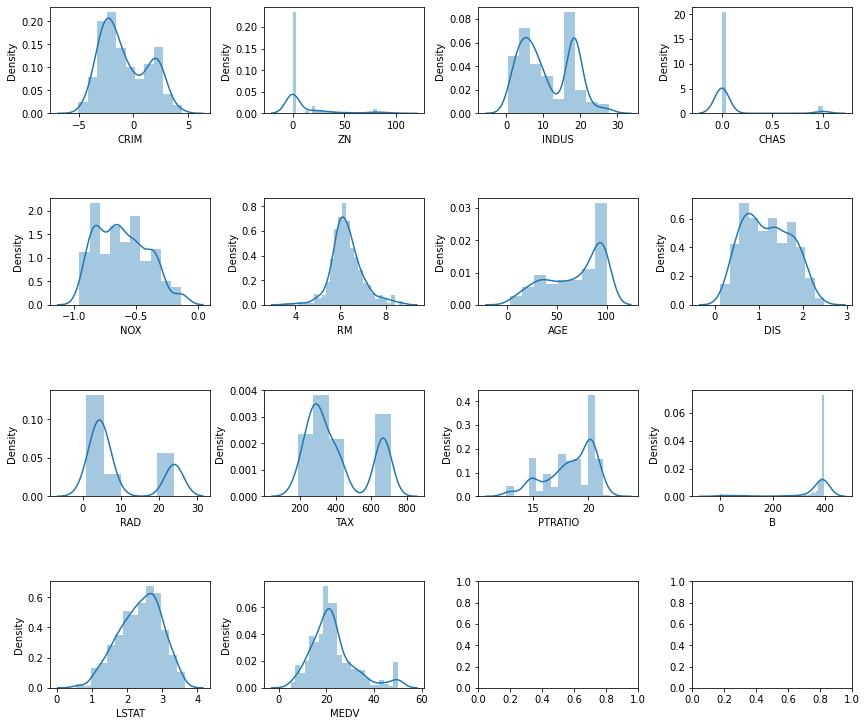

In [22]:
#notice that we create a new data frame here by replacing columns in bdata
#normally it's better to create a data transformer (by using ColumnTransformer and FunctionTransformer in this case.)
new_data = bdata.assign(CRIM=lambda x: np.log(x.CRIM),
                       NOX = lambda x: np.log(x.NOX),
                        DIS = lambda x: np.log(x.DIS),
                        LSTAT = lambda x: np.log(x.LSTAT))

#plot the resulting distributions
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(12, 10))
index = 0
axs = axs.flatten()
for k, v in new_data.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

You can see that the distributions for CRIM, NOX, DIS and LSTAT look less skewed now.

### Outliers

Now we are going to try to remove outliers - those are the observations that are far away from other observations. The easy way to check for outliers in our feature set is by using boxplots: 

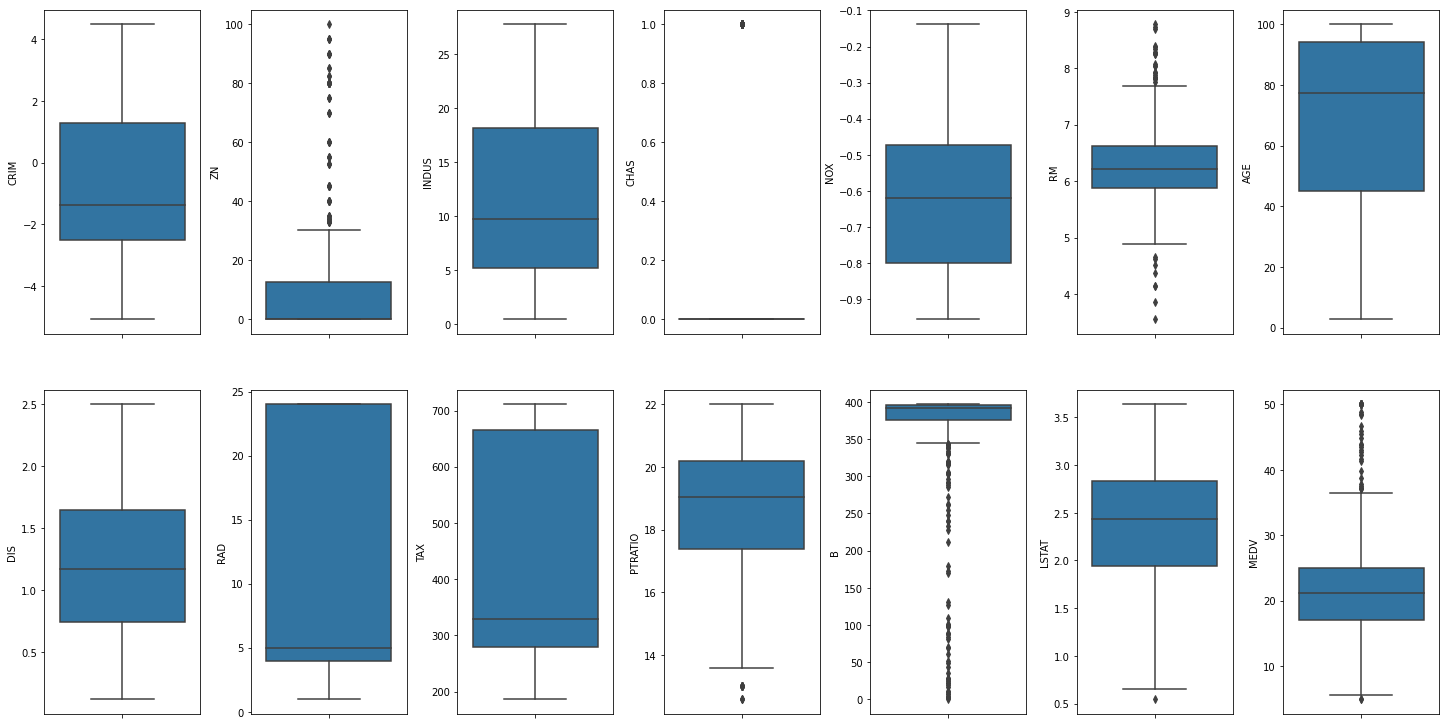

In [23]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k, v in new_data.items():
    sns.boxplot(y=k, data=new_data, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

What you will notice when looking at the plots is that the features ZN, RM and B have many outliers, what's even worse the value we are trying to predict MEDV also has some! We are not going to remove the outliers from the features but we definitely need to get rid of those in MEDV - if you look at the distribution you'll notice that there are a couple of values that are exactly 50 - those are most likely data injected into the set when no real price was available or when it was higher than 50 - let's remove those observations 

C:\Users\jelme\anaconda3\envs\Pyharm\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jelme\anaconda3\envs\Pyharm\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='MEDV', ylabel='Density'>

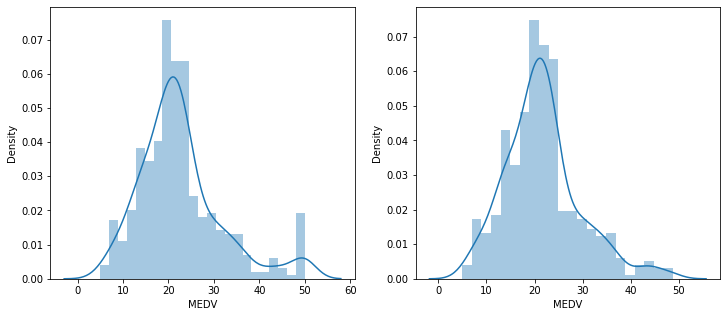

In [24]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
axs.flatten()
sns.distplot(new_data['MEDV'], ax = axs[0])
new_data = new_data[(new_data['MEDV'] != 50)]
sns.distplot(new_data['MEDV'], ax = axs[1])

### Collinearity

The last thing we are going to do is to look at the Collinearity of the features - this is checking whether some features are strongly corellated. Such features shouldn't be used together in the Linear Regression. We are going to look again at the correlations but this time using the [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function of seaborn:

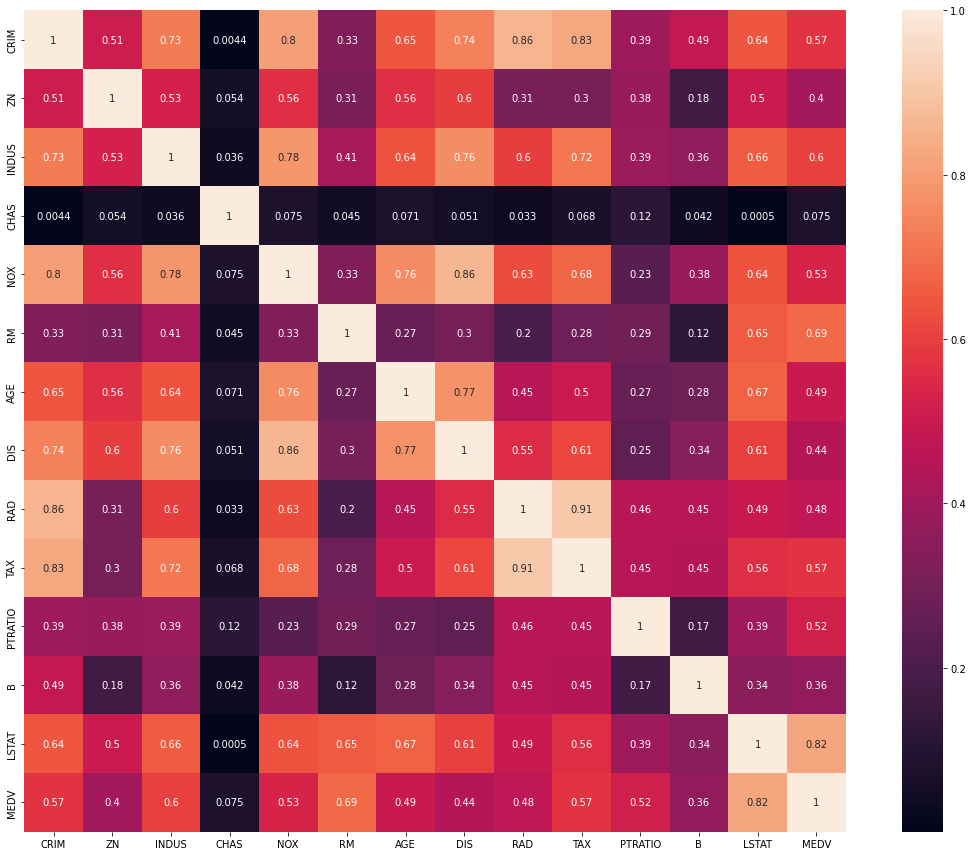

In [25]:
corr = new_data.corr().abs()
plt.figure(figsize=(16, 12))
sns.heatmap(corr, square=True, annot=True)
plt.tight_layout()

In [26]:
prices = new_data['MEDV']
features = new_data[['LSTAT', 'PTRATIO', 'RM', 'INDUS', 'TAX']]

With the features and the values to predict cleaned up and selected your taks is as follows:

1. Build a processing pipeline that includes: addition of polynominal features, feature scaler and a regularized regressor (Linear won't do for poly features) \[1 point\]

2. Split the dataset (new_data) into the training and validation sets and plot the learning curves \[1 point\]

3. Build at least two additional pipelines:

    a) one that includes polynominal features and `LinearRegression`
    
    b) one that includes polynominal features and another kind of regularized Regressor
    
    c) compare the performance of those three approaches by comparing cross-validation scores using the k-fold strategy  \[3 points\]

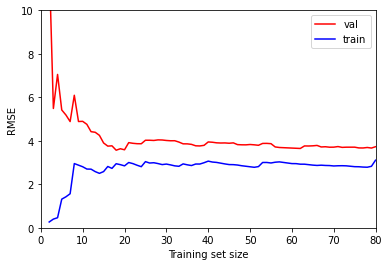

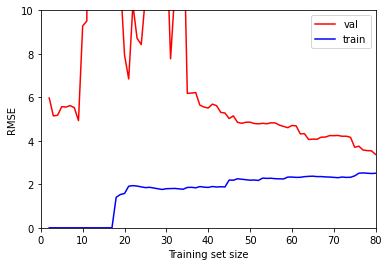

In [49]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures 
# TODO: Split the dataset and plot the learning curves (1 point)

def plot_training_set(pipeline,y_axis,x_axis,size):
    training_set = []
    set_size = []
    validation_set = []

    X_train, X_val, y_train, y_val = train_test_split(y_axis, x_axis, test_size=size)

    for i in range(2,len(X_train)):
        pipeline.fit(X_train[:i], y_train[:i])
        y_train_predict = pipeline.predict(X_train[:i])
        y_val_predict = pipeline.predict(X_val)
        training_set.append(np.sqrt(mean_squared_error(y_train[:i], y_train_predict)))
        validation_set.append(np.sqrt(mean_squared_error(y_val, y_val_predict)))
        set_size.append(i)

    plt.axis([0, 80,0, 10])
    plt.xlabel('Training set size')
    plt.ylabel('RMSE')
    plt.plot(set_size,validation_set,'r',label='val')
    plt.plot(set_size,training_set,'b',label='train')
    plt.legend(loc="upper right")
    plt.show()

poly_ridge_pipeline = Pipeline([
 ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
 ("std_scaler", StandardScaler()),
 ("ridge", Ridge())
 ])

plot_training_set(poly_ridge_pipeline,features,prices,0.2)


poly_pipeline= Pipeline([
 ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
 ("std_scaler", StandardScaler()),
 ("lin_reg", LinearRegression())
 ])

plot_training_set(poly_pipeline,features,prices,0.2)

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def kcross(regressor, X, y):
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    scores = cross_val_score(regressor, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    return scores

scores = kcross(poly_ridge_pipeline, features, prices)
print(f"ridge regressor MSE: Mean={-scores.mean()} Std={scores.std()} ")
scores = kcross(poly_pipeline, features, prices)
print(f"linear regressor MSE: Mean={-scores.mean()} Std={scores.std()} ")

ridge regressor MSE: Mean=3.173355089384547 Std=0.28943086020701675 
linear regressor MSE: Mean=3.1679707018194407 Std=0.3042197374570477 
